In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### **Load Polar Data**
- More of the gold standard, has the correct number of peaks. Not the PolarHRM.

In [2]:
polar_data = pd.read_csv("HRV-data/polar.csv")
print(polar_data.head())

   timestamp_ms  value
0  5.996162e+11     19
1  5.996162e+11     19
2  5.996162e+11     16
3  5.996162e+11     21
4  5.996162e+11     30


### **Plot Unfiltered Polar Data**

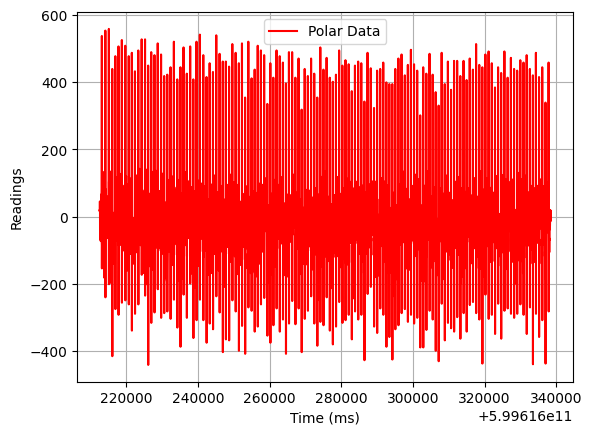

In [3]:
x_axis = polar_data["timestamp_ms"]
y_axis = polar_data["value"]

plt.plot(x_axis, y_axis, c='r', label="Polar Data")
plt.legend()
plt.grid(True, 'both', 'both')
plt.xlabel("Time (ms)")
plt.ylabel("Readings")
plt.show()